In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import warnings

# Ignore a bunch of Arviz/pymc3 deprecated warnings
warnings.filterwarnings('ignore')

## 8H1

In [2]:
TULIPS_DATA = '../../data/tulips.csv'
df = pd.read_csv(f'{TULIPS_DATA}')
df['bed'].unique()

array(['a', 'b', 'c'], dtype=object)

### The Model

We create an index variable for `bed`. The model is modified as follows:
$$
\begin{align*}
~ B_i      & \sim N(\mu_i, \sigma) \\
\mu_i      & = \alpha + \beta_W (W_i - \bar{W}) + \beta_S (S_i - \bar{S}) 
                      + \beta_{WS} (W_i - \bar{W}) (S_i - \bar{S}) 
                      + \beta_{a} \text{Bed}_{a} + \beta_{b} \text{Bed}_{b} + \beta_{c} \text{Bed}_{c} \\
\alpha     & \sim N(0.5, 0.25) \\
\beta_W    & \sim N(0, 0.25) \\
\beta_S    & \sim N(0, 0.25) \\
\beta_{WS} & \sim N(0, 0.25),
\end{align*}
$$
where $\text{Bed}_{x} = 1$ for a data point iff that datum is from bed $x$. We still need priors for each of the $\beta_{a}, \beta_{b}, \beta_{c}$. If we assume that the outcome `bloom` is determined by the `bed` alone and that none of the other factors (`shade` and `water`) play a role, then each of the $\beta_{x}$ should be equal to the mean bloom size of $0.5$. If we assume that the prior distribution of $\beta_{x}$ is normal and want $95\%$ of the mass of the distribution to be within $[0, 1]$, the range of minimum to maximum bloom sizes, we would require the standard deviation to be $0.25$. 

In [3]:
df['blooms_std'] = df['blooms'] / df['blooms'].max()
df['water_cent'] = df['water'] - df['water'].mean()
df['shade_cent'] = df['shade'] - df['shade'].mean()

df = pd.get_dummies(df, columns=['bed'], prefix='bed')

In [4]:
df.head()

,water,shade,blooms,blooms_std,water_cent,shade_cent,bed_a,bed_b,bed_c
0,1,1,0.00,0.000000,-1.0,-1.0,1,0,0
1,1,2,0.00,0.000000,-1.0,0.0,1,0,0
2,1,3,111.04,0.307029,-1.0,1.0,1,0,0
3,2,1,183.47,0.507300,0.0,-1.0,1,0,0
4,2,2,59.16,0.163579,0.0,0.0,1,0,0


In [5]:
n_beds = 3

with pm.Model() as m_8_5_cat:
    a = pm.Normal('a', mu=0.5, sigma=0.25)
    bw = pm.Normal('bw', mu=0, sigma=0.25)
    bs = pm.Normal('bs', mu=0, sigma=0.25)
    bws = pm.Normal('bws', mu=0, sigma=0.25)
    bed = pm.Normal('bed', mu=0.5, sigma=0.25, shape=(n_beds))
    
    mu = pm.Deterministic('mu', a + bw * df['water_cent'] + bs * df['shade_cent'] + 
                          bws * df['water_cent'] * df['shade_cent'] + 
                          bed[0] * df['bed_a'] + bed[1] * df['bed_b'] + bed[2] * df['bed_c'])
    sigma = pm.Exponential('sigma', lam=1)
    
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    
    trace_8_5_cat = pm.sample(500, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bed, bws, bs, bw, a]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [6]:
az.summary(trace_8_5_cat, var_names=['sigma', 'bed', 'bws', 'bs', 'bw', 'a'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.132,0.022,0.101,0.166,0.001,0.000,941.0,824.0,1.00
bed[0],0.254,0.126,0.046,0.452,0.005,0.003,657.0,1010.0,1.01
bed[1],0.379,0.125,0.197,0.595,0.005,0.003,637.0,958.0,1.01
bed[2],0.390,0.127,0.191,0.595,0.005,0.003,681.0,921.0,1.00
bws,-0.141,0.037,-0.200,-0.078,0.001,0.001,1675.0,1228.0,1.00
bs,-0.113,0.032,-0.164,-0.065,0.001,0.001,1650.0,1182.0,1.00
bw,0.206,0.030,0.160,0.253,0.001,0.001,1594.0,1192.0,1.01
a,0.020,0.122,-0.181,0.212,0.005,0.003,644.0,860.0,1.01


### Discussion

The estimates of $\beta_w$, $\beta_s$ and $\beta_{ws}$ are almost the same as in model m_8_5. The estimate of $\alpha$ has changed and there seems to be little association with the outcome. This model seems to equivalent to one in which we omit the intercept $\alpha$ altogether and have a different intercept for each `bed`.

In [7]:
n_beds = 3

with pm.Model() as m_8_5_cat2:
    bw = pm.Normal('bw', mu=0, sigma=0.25)
    bs = pm.Normal('bs', mu=0, sigma=0.25)
    bws = pm.Normal('bws', mu=0, sigma=0.25)
    bed = pm.Normal('bed', mu=0.5, sigma=0.25, shape=(n_beds))
    
    mu = pm.Deterministic('mu', bw * df['water_cent'] + bs * df['shade_cent'] + 
                          bws * df['water_cent'] * df['shade_cent'] + 
                          bed[0] * df['bed_a'] + bed[1] * df['bed_b'] + bed[2] * df['bed_c'])
    sigma = pm.Exponential('sigma', lam=1)
    
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    
    trace_8_5_cat2 = pm.sample(500, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bed, bws, bs, bw]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 9 seconds.


In [8]:
az.summary(trace_8_5_cat2, var_names=['sigma', 'bed', 'bws', 'bs', 'bw'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.130,0.021,0.098,0.161,0.001,0.000,1608.0,1391.0,1.00
bed[0],0.274,0.043,0.206,0.342,0.001,0.001,2525.0,1789.0,1.00
bed[1],0.397,0.043,0.330,0.466,0.001,0.001,2178.0,1520.0,1.00
bed[2],0.411,0.044,0.344,0.482,0.001,0.001,2510.0,1584.0,1.00
bws,-0.144,0.038,-0.206,-0.087,0.001,0.001,2327.0,1407.0,1.00
bs,-0.113,0.030,-0.164,-0.070,0.001,0.000,1963.0,1564.0,1.01
bw,0.207,0.031,0.155,0.252,0.001,0.000,2571.0,1465.0,1.00


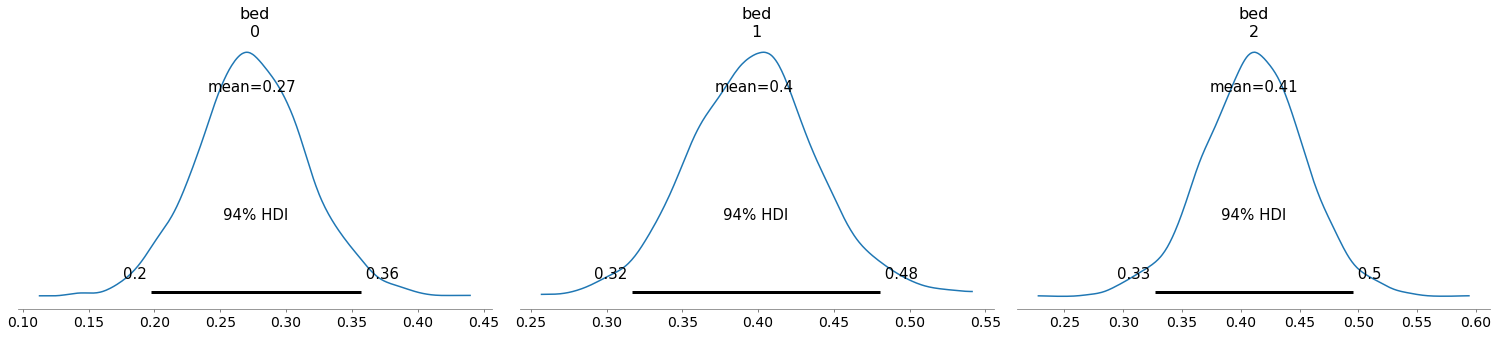

In [9]:
az.plot_posterior(trace_8_5_cat2, var_names=['bed'])
plt.show()

## The Original Interaction Model

In [10]:
with pm.Model() as m_8_5:
    a = pm.Normal('a', mu=0.5, sigma=0.25)
    bw = pm.Normal('bw', mu=0, sigma=0.25)
    bs = pm.Normal('bs', mu=0, sigma=0.25)
    bws = pm.Normal('bws', mu=0, sigma=0.25)
    
    mu = pm.Deterministic('mu', a + bw * df['water_cent'] + bs * df['shade_cent'] + 
                          bws * df['water_cent'] * df['shade_cent'])
    sigma = pm.Exponential('sigma', lam=1)
    
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    
    trace_8_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bws, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


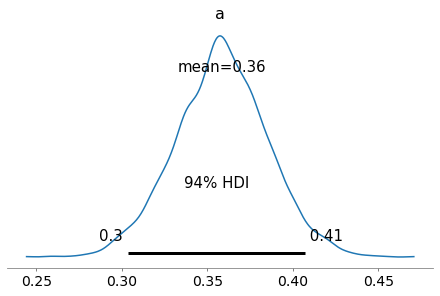

In [11]:
az.plot_posterior(trace_8_5, var_names=['a'])
plt.show()

In [12]:
with m_8_5:
    m_8_5_post = pm.sample_posterior_predictive(trace_8_5, var_names=['a'])

with m_8_5_cat2:
    m_8_5_cat2_post = pm.sample_posterior_predictive(trace_8_5_cat2, var_names=['bed'])

In [13]:
m_8_5_cat2_post['bed'].shape

(2000, 3)

In [14]:
alpha_mean = m_8_5_post['a'].mean()
bed_a_mean = m_8_5_cat2_post['bed'][:, 0].mean()
bed_b_mean = m_8_5_cat2_post['bed'][:, 1].mean()
bed_c_mean = m_8_5_cat2_post['bed'][:, 2].mean()
bed_mean = (bed_a_mean + bed_b_mean + bed_c_mean) / 3.0

In [15]:
alpha_mean, bed_mean 

(0.3583675349652538, 0.3607760037270447)

In [16]:
trace_dict = {'m_8_5': trace_8_5, 'm_8_5_c': trace_8_5_cat2}
az.compare(trace_dict, ic='waic', scale='deviance')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_5_c,0,-28.167086,5.915940,0.000000,0.742286,6.413671,0.000000,True,deviance
m_8_5,1,-25.041227,4.329204,3.125859,0.257714,7.492242,5.399398,True,deviance
